### Data Loader Playground

This is a notebook to play around with the data loader and make sure it's working as expected.

In [1]:
import sys
sys.path.append('/workspaces/unlearning-research-meta/code/')
from data_loader import (
    get_synthetic_linear_stream,
    parse_event_record,
)
from data_loader.linear import set_rotation_by_PT
import numpy as np
import matplotlib.pyplot as plt

# Optional: use pandas if available
try:
    import pandas as pd
except ImportError:
    pd = None
    print("pandas not found; proceeding without DataFrame conveniences.")


## Setup and parameters

Configure the synthetic linear stream parameters. You can switch path_type between 'rotating', 'drift', and 'static'. For rotating paths, you can either set rotate_angle directly or target a total path length PT using set_rotation_by_PT.

In [2]:
# Stream parameters
N = 2000  # number of events to sample

dim = 20
seed = 123
noise_std = 0.2

# Covariance settings
cond_number = 10.0
feature_scale = 1.0

# Path settings
path_type = 'rotating'  # options: 'rotating', 'drift', 'static'
fix_w_norm = True
w_scale = None  # e.g., 5.0 to fix norm explicitly

# For rotating path, you can choose either rotate_angle or target_PT
target_PT = 50.0  # set None to use rotate_angle directly
T_for_target = N  # horizon to match PT across
if target_PT is not None and path_type == 'rotating':
    # Estimate w_norm to pick rotation angle (refined implicitly once stream runs)
    assumed_w_norm = 1.0 if w_scale is None else float(w_scale)
    rotate_angle = set_rotation_by_PT(T_for_target, assumed_w_norm, target_PT)
else:
    rotate_angle = 0.02  # radians per step

# Drift rate for 'drift' path
drift_rate = 0.001

params = dict(
    dim=dim,
    seed=seed,
    noise_std=noise_std,
    cond_number=cond_number,
    feature_scale=feature_scale,
    path_type=path_type,
    rotate_angle=rotate_angle,
    drift_rate=drift_rate,
    w_scale=w_scale,
    fix_w_norm=fix_w_norm,
    strong_convexity_estimation=True,
)

print("Params:", params)

Params: {'dim': 20, 'seed': 123, 'noise_std': 0.2, 'cond_number': 10.0, 'feature_scale': 1.0, 'path_type': 'rotating', 'rotate_angle': np.float64(0.025000651087447295), 'drift_rate': 0.001, 'w_scale': None, 'fix_w_norm': True, 'strong_convexity_estimation': True}


In [3]:
from itertools import islice

# Generate records
stream = get_synthetic_linear_stream(**params)
records = [next(stream) for _ in range(N)]

# Parse into arrays
xs = np.vstack([r['x'] for r in records]).astype(np.float32)
ys = np.array([r['y'] for r in records], dtype=float)
metrics_list = [r['metrics'] for r in records]

# Helper to collect metrics safely
def pick(key, default=np.nan):
    return np.array([m.get(key, default) for m in metrics_list], dtype=float)

metric_keys = ['x_norm','w_star_norm','noise','delta_P','lambda_est','P_T_true','rotate_angle','drift_rate']
metrics = {k: pick(k) for k in metric_keys}

# Cumulative path length from deltas and true tracker from generator
cum_delta_P = np.nancumsum(np.nan_to_num(metrics.get('delta_P', np.zeros(N))))
P_T_true = metrics.get('P_T_true', np.full(N, np.nan))

# Empirical covariance and condition number
emp_cov = np.cov(xs, rowvar=False)
eigvals = np.linalg.eigvalsh(emp_cov)
cond_emp = float(eigvals.max()/eigvals.min()) if eigvals.min() > 1e-12 else np.inf

print(f"Sampled xs: {xs.shape}, ys: {ys.shape}")
print(f"Empirical cond number ~ {cond_emp:.2f}")
print("First metrics:", {k: metrics[k][0] for k in metrics})

Sampled xs: (2000, 20), ys: (2000,)
Empirical cond number ~ 10.57
First metrics: {'x_norm': np.float64(2.499103307723999), 'w_star_norm': np.float64(3.6215304423722197), 'noise': np.float64(-0.4414942196399609), 'delta_P': np.float64(0.026382144372566488), 'lambda_est': np.float64(nan), 'P_T_true': np.float64(0.026382144372566488), 'rotate_angle': np.float64(0.025000651087447295), 'drift_rate': np.float64(0.001)}


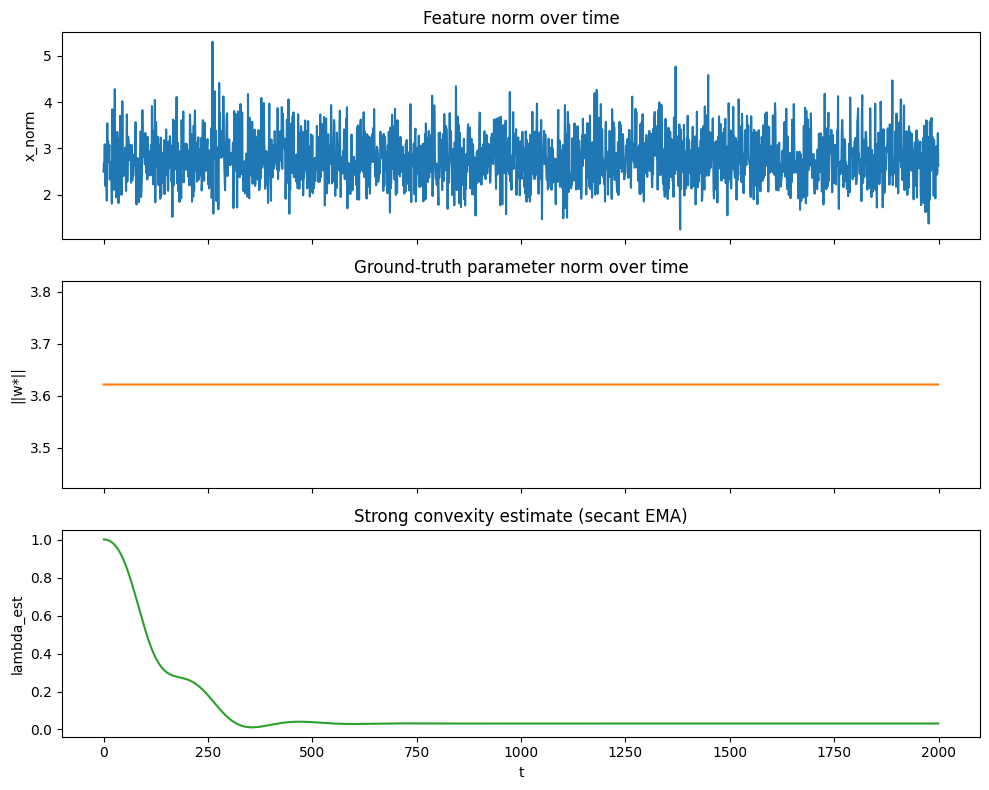

In [4]:
# Time series of key metrics
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axes[0].plot(metrics.get('x_norm', np.nan*np.ones(N)), color='tab:blue')
axes[0].set_ylabel('x_norm')
axes[0].set_title('Feature norm over time')

axes[1].plot(metrics.get('w_star_norm', np.nan*np.ones(N)), color='tab:orange')
axes[1].set_ylabel('||w*||')
axes[1].set_title('Ground-truth parameter norm over time')

axes[2].plot(metrics.get('lambda_est', np.nan*np.ones(N)), color='tab:green')
axes[2].set_ylabel('lambda_est')
axes[2].set_title('Strong convexity estimate (secant EMA)')
axes[2].set_xlabel('t')

plt.tight_layout()
plt.show()

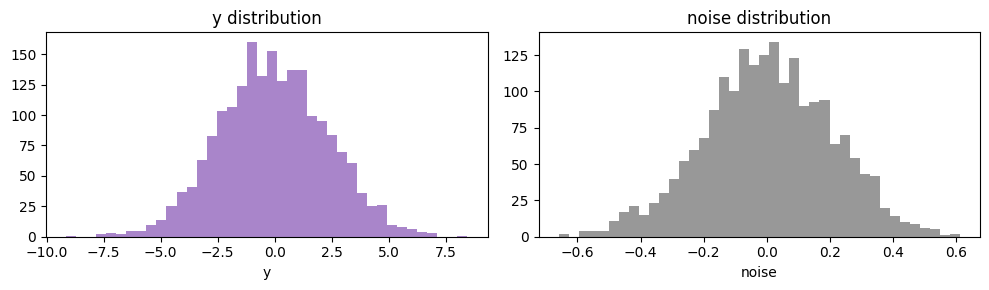

In [5]:
# Distributions of outputs and noise
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].hist(ys, bins=40, color='tab:purple', alpha=0.8)
axes[0].set_title('y distribution')
axes[0].set_xlabel('y')

noise_vals = metrics.get('noise', np.nan*np.ones(N))
axes[1].hist(noise_vals[~np.isnan(noise_vals)], bins=40, color='tab:gray', alpha=0.8)
axes[1].set_title('noise distribution')
axes[1].set_xlabel('noise')

plt.tight_layout()
plt.show()

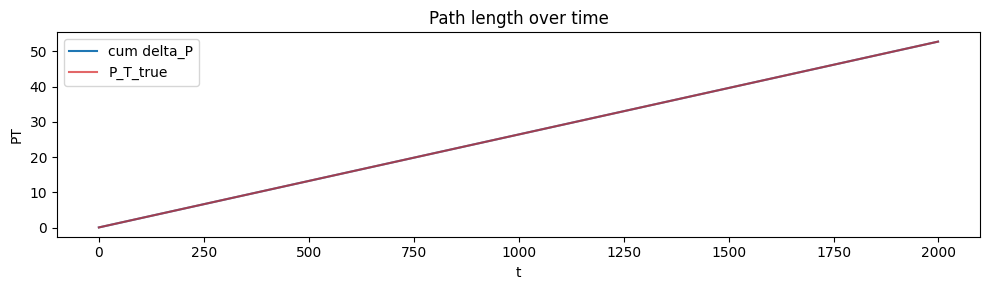

In [6]:
# Path length tracking: cumulative delta_P vs P_T_true
plt.figure(figsize=(10, 3))
plt.plot(cum_delta_P, label='cum delta_P', color='tab:blue')
if np.isfinite(P_T_true).any():
    plt.plot(P_T_true, label='P_T_true', color='tab:red', alpha=0.7)
plt.title('Path length over time')
plt.xlabel('t')
plt.ylabel('PT')
plt.legend()
plt.tight_layout()
plt.show()

## Data Loader Configurations

There are a few too many knobs on the data loader for my liking. I'd like to reduce the complexity of the data loader and ideally reduce some of the configurable parameters, as well. 

This should also include a structural analysis. What would it look like to only support a synthetic linear stream with rotating drift parameters? This is really the only stream that I use for testing. What would it look like to have a bare-metal data loader that also fulfilled the requirements for testing the memory pair?

### Notes from Kennon:
- Consider trimming the paths to default to rotating. This would ideally reduce the complexity of some of the code.
- Consider also removing all but the linear stream. MNIST/COV datasets aren't being used for experiments.
- Find the difference between eigenvalues and the condition number. Which is preferred for the use in a rotating stream?
- Consider snipping the `rand_orth_seed` because what does that do and why isn't this using the `seed` value?
- What is a path controller? Isn't this something that should be implemented for all runs? When would be an instance where I wouldn't need a path controller?
- If I get rid of the extraneous path options, will I also be able to cut down on the number of parameter path controls? 

### GPT Notes:

Here are the knobs you can set on the linear synthetic stream, i.e., `data_loader.linear.get_synthetic_linear_stream`:

- dim (default 20): Feature dimension.
- seed (default 42): RNG seed.
- noise_std (default 0.1): Std dev of additive Gaussian noise on y.
- use_event_schema (default True): Kept for compatibility; the stream always emits event records.
- eigs (default None): Explicit eigenvalues for the feature covariance. If set, overrides cond_number.
- cond_number (default None): Target condition number used to shape covariance eigenvalues if eigs not provided.
- rand_orth_seed (default 42): Seed for random orthogonal basis used in covariance construction.
- feature_scale (default 1.0): Global scale applied to features after covariance generation.

Parameter path controls via `data_loader.linear.ParameterPathController`:
- path_type (default "rotating"): One of "rotating", "drift", "static".
- path_control (default True): Whether to apply the path controller at all.
- rotate_angle (default 0.01): Radians per step for rotating path.
- drift_rate (default 0.001): Per-step Gaussian drift magnitude for drift path.
- w_scale (default None): If set, initializes and (optionally) maintains ||w*|| at this value.
- fix_w_norm (default True): If True, keeps ||w*|| fixed during path updates.

Diagnostics/config propagation (surfaced in event metrics and used by tests like experiment/tests/test_stream_params.py):
- strong_convexity_estimation (default True): Enable online lambda estimate in metrics.
- G_hat, D_hat, c_hat, C_hat (all default None): Optional values to record in metrics for gradient bound, diameter, and curvature proxies.

Helper for configuring rotation by target path length:
- `data_loader.linear.set_rotation_by_PT`: Compute rotate_angle from a target total path length over a horizon (used in your notebook).

In [7]:
# Fidelity checks to verify parameters are reflected in the stream
results = {}

# 1) Noise std fidelity
noise_vals = metrics.get('noise', np.nan*np.ones(N))
noise_vals = noise_vals[~np.isnan(noise_vals)]
if noise_vals.size > 10:
    est_noise_std = float(np.std(noise_vals))
    rel_err = abs(est_noise_std - noise_std) / max(noise_std, 1e-12)
    results['noise_std'] = dict(target=noise_std, estimated=est_noise_std, rel_error=rel_err, pass_=rel_err < 0.3)
else:
    results['noise_std'] = dict(target=noise_std, estimated=np.nan, rel_error=np.nan, pass_=False)

# 2) Condition number fidelity (empirical features)
if cond_number is not None and np.isfinite(cond_emp):
    rel_err = abs(cond_emp - cond_number) / max(cond_number, 1e-12)
    results['cond_number'] = dict(target=cond_number, estimated=float(cond_emp), rel_error=rel_err, pass_=rel_err < 0.5)

# 3) w* norm stability under fix_w_norm
w_norm_vals = metrics.get('w_star_norm', np.nan*np.ones(N))
if fix_w_norm and np.isfinite(w_norm_vals).any():
    mu = np.nanmean(w_norm_vals)
    sd = np.nanstd(w_norm_vals)
    ratio = sd / max(mu, 1e-12)
    results['w_norm_stability'] = dict(mean=mu, std=sd, cv=ratio, pass_=ratio < 0.05)

# 4) Path increment fidelity
avg_delta = float(np.nanmean(metrics.get('delta_P', np.nan*np.ones(N))))
if path_type == 'rotating':
    wbar = float(np.nanmean(w_norm_vals)) if np.isfinite(w_norm_vals).any() else 1.0
    theta = float(rotate_angle)
    # Model rotates only in first two dims; expected projection ~ sqrt(2/dim)
    approx_plane_factor = np.sqrt(2.0 / max(dim, 1))
    expected = 2 * wbar * approx_plane_factor * np.sin(theta / 2.0)
    upper_bound = 2 * wbar * np.sin(theta / 2.0)
    rel_err = abs(avg_delta - expected) / max(expected, 1e-12)
    pass_cond = (rel_err < 0.5) or (0 < avg_delta <= upper_bound * 1.05)
    results['delta_P_per_step'] = dict(model='rotating', expected=expected, upper_bound=upper_bound, observed=avg_delta, rel_error=rel_err, pass_=pass_cond)
elif path_type == 'drift':
    # Approximate: E[||drift||] ~ drift_rate * sqrt(dim)
    expected = drift_rate * np.sqrt(dim)
    rel_err = abs(avg_delta - expected) / max(expected, 1e-12)
    results['delta_P_per_step'] = dict(model='drift', expected=expected, observed=avg_delta, rel_error=rel_err, pass_=rel_err < 0.5)

# 5) P_T cumulative consistency
pt_true_vals = P_T_true
if np.isfinite(pt_true_vals).any():
    last_true = float(pt_true_vals[~np.isnan(pt_true_vals)][-1])
    last_est = float(cum_delta_P[-1])
    rel_err = abs(last_est - last_true) / max(last_true, 1e-12)
    results['PT_cumulative'] = dict(true=last_true, from_deltas=last_est, rel_error=rel_err, pass_=rel_err < 0.1)

# Print a compact report
print("Fidelity report:")
for k, v in results.items():
    status = 'PASS' if v.get('pass_') else 'FAIL'
    print(f"- {k}: {status} -> {v}")

Fidelity report:
- noise_std: PASS -> {'target': 0.2, 'estimated': 0.20379458524609823, 'rel_error': 0.018972926230491072, 'pass_': True}
- cond_number: PASS -> {'target': 10.0, 'estimated': 10.570551272496065, 'rel_error': 0.057055127249606485, 'pass_': True}
- w_norm_stability: PASS -> {'mean': np.float64(3.621530442372219), 'std': np.float64(4.1409979385700913e-16), 'cv': np.float64(1.1434386661837928e-16), 'pass_': np.True_}
- delta_P_per_step: PASS -> {'model': 'rotating', 'expected': np.float64(0.028630712033833446), 'upper_bound': np.float64(0.09053826105930549), 'observed': 0.026382144372566446, 'rel_error': np.float64(0.0785369102455372), 'pass_': np.True_}
- PT_cumulative: PASS -> {'true': 52.764288745134365, 'from_deltas': 52.764288745134365, 'rel_error': 0.0, 'pass_': True}
